In [1]:
import sionna.rt
import xarray as xr
import time
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies, SceneObject, RadioMaterial
from sionna.rt.scene import simple_reflector, box_two_screens, triple_reflector
print("Sionna version:", sionna.rt.__version__)
print("tf version:", tf.__version__)

2025-10-02 14:08:10.847955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759414090.901073  348036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759414090.917755  348036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759414090.958505  348036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759414090.958531  348036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759414090.958535  348036 computation_placer.cc:177] computation placer alr

Sionna version: 1.0.2
tf version: 2.19.0


In [2]:
# select GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("GPU:", gpus)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU') # only use the first GPU
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    print("Using GPU:", gpus[0].name)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

else:
  print("No GPU found, using CPU.")



GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
Using GPU: /physical_device:GPU:0


I0000 00:00:1759414097.371102  348036 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13741 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:00.0, compute capability: 7.5


## Loading and editing the scene

In [3]:
# Load scene
#scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

scene = load_scene(triple_reflector, merge_shapes=False)


In [4]:

# print name of all objects in the scene
print(scene.objects.keys())

# adjust the position of the large reflector
reflector_height = 2.6 # meters
scene.objects['large_reflector'].position = [0, 0, reflector_height]
print(f"reflector height set to {scene.objects['large_reflector'].position}")

# move small reflector cause not needed
scene.objects['small_reflector'].position = [0, 0, -0.1]


# load config file
N_antennas = 1
pattern = "tr38901" #"iso"#
tx_height = 2.5
rx_height = 1
polarization = "V"
scene.tx_array = PlanarArray(num_rows=N_antennas,
                                num_cols=N_antennas,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=pattern,
                                polarization=polarization)

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=N_antennas,
                            num_cols=N_antennas,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=pattern,
                            polarization=polarization)
                            # Create transmitter

tx = Transmitter(name="tx",
                 position=[0, 0, tx_height],
                 display_radius=0.5)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx_y = 0.1
rx = Receiver(name="rx",
              position=[0, 0, rx_height],
              display_radius=0.5)

# Add receiver instance to scene
scene.add(rx)

tx.look_at([0,0,0]) # Transmitter points down
rx.look_at([0,0,3]) # Receiver points up

dict_keys(['floor', 'small_reflector', 'large_reflector'])
reflector height set to [[0, 0, 2.6]]


In [5]:
# change radio materials to work above 100 GHz
def ituf_metal_callback(f_hz):
  f_ghz = f_hz / 1e9
  relative_permittivity = 1.0  
  c, d = 10**7, 0.0
  conductivity = c*np.power(f_ghz, d)
  return (relative_permittivity, conductivity)

# update materials in the scene
floor = scene.get("floor")
floor.radio_material.frequency_update_callback = ituf_metal_callback
print(floor.radio_material.name)
print(floor.radio_material.frequency_update_callback)

large_reflector = scene.get("large_reflector")
large_reflector.radio_material.frequency_update_callback = ituf_metal_callback
print(large_reflector.radio_material.name)
print(large_reflector.radio_material.frequency_update_callback)

small_reflector = scene.get("small_reflector")
small_reflector.radio_material.frequency_update_callback = ituf_metal_callback
print(small_reflector.radio_material.name)
print(small_reflector.radio_material.frequency_update_callback)


itu_metal
<function ituf_metal_callback at 0x76c479c66520>
itu_metal
<function ituf_metal_callback at 0x76c479c66520>
itu_metal
<function ituf_metal_callback at 0x76c479c66520>


In [6]:
scene.preview(); # open interactive window to preview the scene

## Check radiation patterns


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

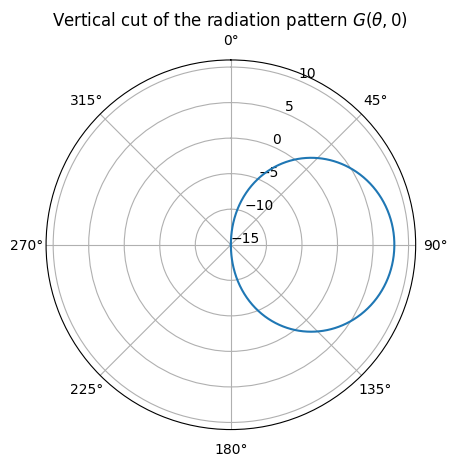

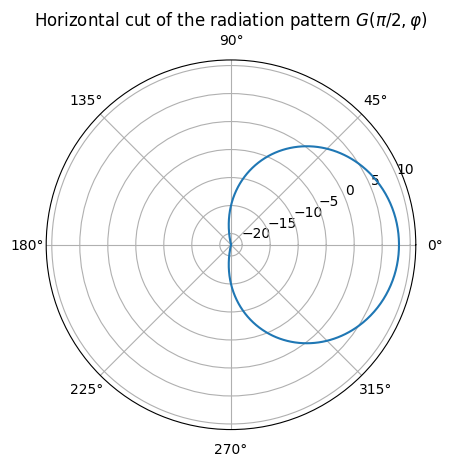

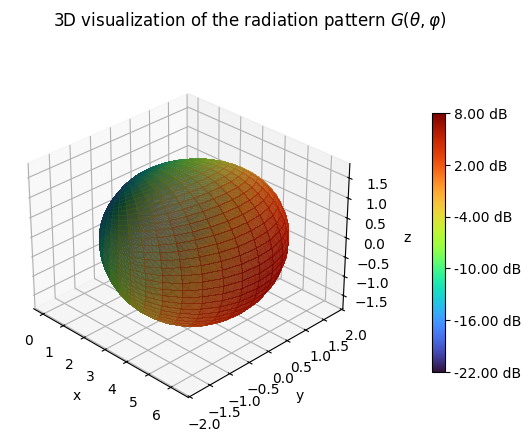

In [7]:
scene.tx_array.antenna_pattern.show()


## run the path solver

In [8]:


# OFDM system parameters
BW = 12.5e+9
num_subcarriers = 1024
subcarrier_spacing = BW / num_subcarriers
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing) # Compute baseband frequencies of subcarriers relative to the carrier frequency

# set scene frequency
scene.frequency = 157.75e+9# Set frequency to fc 

# Instantiate a path solver
p_solver  = PathSolver()

# compute the paths
paths = p_solver(scene=scene,
                max_depth=20,
                los=True,
                specular_reflection=True,
                diffuse_reflection=False, # no scattering
                refraction=True,
                synthetic_array=False,
                seed=41)



Shape of h_freq:  (1, 1, 1, 1, 1, 1024)
Shape of h_freq reshaped:  (1024,)


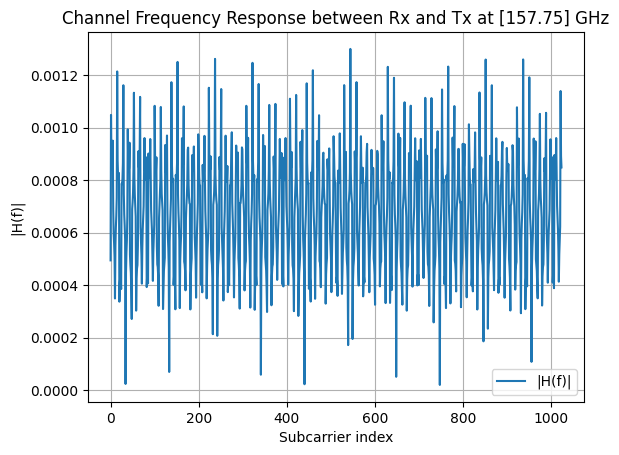

In [9]:
# Compute channel frequency response
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                    normalize_delays=True,
                    out_type="numpy")
print("Shape of h_freq: ", h_freq.shape)

# reshape to [nr_rx_antennas, nr_tx_antennas, nr_subcarriers]
h_freq = np.squeeze(h_freq)
print("Shape of h_freq reshaped: ", h_freq.shape)

# plot
plt.plot(np.abs(h_freq[:]), label='|H(f)|')
plt.xlabel('Subcarrier index')
plt.ylabel('|H(f)|')
plt.title(f'Channel Frequency Response between Rx and Tx at {scene.frequency/1e9} GHz')
plt.grid()
plt.legend()           
plt.show()

a shape: (1, 1, 1, 1, 41, 1), tau shape: (1, 1, 1, 1, 41)
[  5.0034614   5.670589   11.674744   12.341871   22.348793   23.015923
  29.020077   29.687202   39.694126   40.36126    46.36541    47.032536
  57.039463   57.706593   63.710747   64.37788    74.384796   75.05193
  81.05608    81.72321    91.73013    92.39726    98.40142    99.06855
 109.07546   109.74259   115.74675   116.41388   126.42079   127.08792
 133.09206   133.7592    143.7661    144.43323   150.4374    151.10452
 161.11143   161.77856   167.7827    168.44984   178.45676  ]
[4.0466898e-07 3.1422038e-13 7.4130334e-08 6.6157330e-11 2.0175847e-11
 1.8972840e-14 1.1934159e-08 1.1373644e-11 6.3618841e-12 6.1370298e-15
 4.6504969e-09 4.5075432e-12 3.0646846e-12 2.9863125e-15 2.4499687e-09
 2.3931059e-12 1.7925315e-12 1.7561464e-15 1.5056123e-09 1.4772117e-12
 1.1724909e-12 1.1525630e-15 1.0162018e-09 9.9990881e-13 8.2485548e-13
 8.1270095e-16 7.3057282e-10 7.2031243e-13 6.1079207e-13 6.0279703e-16
 5.4963606e-10 5.4272700e-

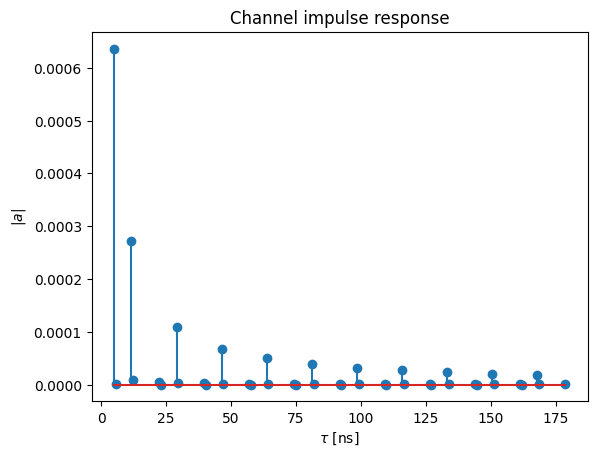

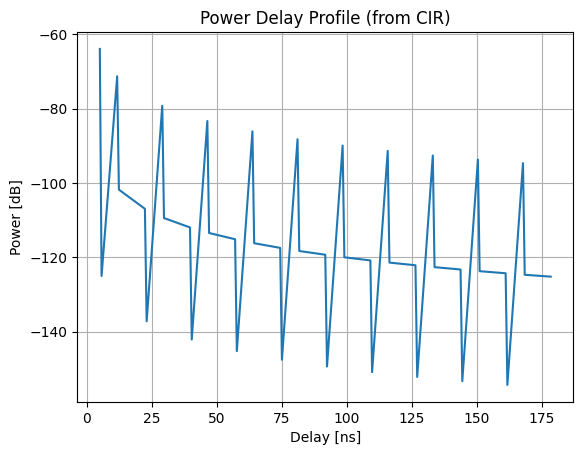

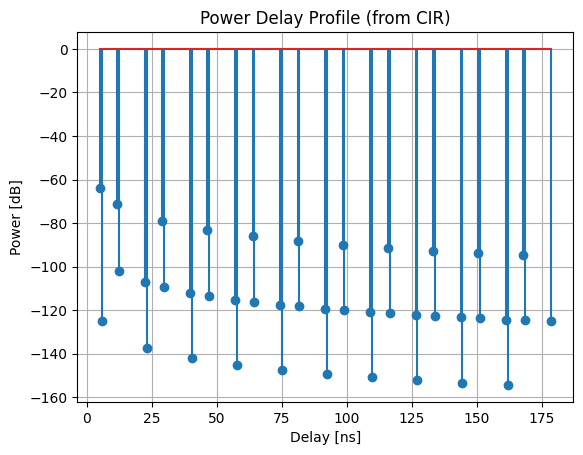

power: [-120.83622   -91.363365 -122.14107   -92.59925  -123.28084   -93.68633
 -124.29325   -94.65718  -125.2044    -63.929    -125.02766  -101.79422
 -137.21867  -109.441    -142.12042  -113.4606   -145.24866  -116.21039
 -147.55438  -118.30557  -149.38336  -120.0004   -150.9007   -121.42479
 -152.19829  -122.65419  -153.33257  -123.736275 -154.34065  -124.703156
  -71.30004  -106.95168   -79.232086 -111.96414   -83.325005 -115.13615
  -86.1084   -117.46533   -88.22287  -119.3089    -89.9302  ]


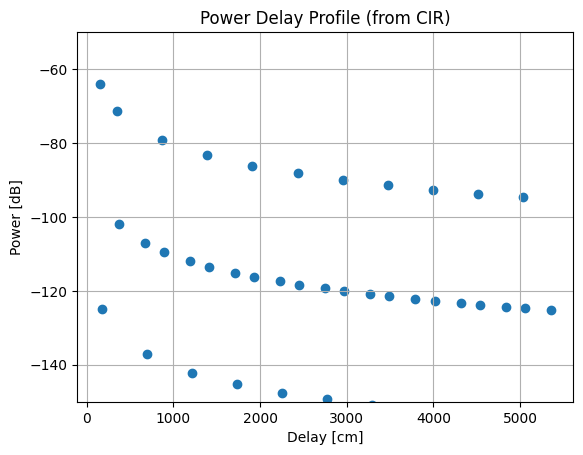

In [10]:
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
print(f'a shape: {a.shape}, tau shape: {tau.shape}')

t = np.squeeze(tau)/1e-9 # Scale to ns
a_abs = np.abs(np.squeeze(a))
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");


power = np.abs(np.squeeze(a))**2   # path power
# Sort by delay
sort_idx = np.argsort(t)
t_sorted = t[sort_idx]
power_sorted = power[sort_idx]
print(t_sorted)
print(power_sorted)
plt.figure()
plt.plot(t_sorted, 10*np.log10(power_sorted))
plt.xlabel("Delay [ns]")
plt.ylabel("Power [dB]")
plt.title("Power Delay Profile (from CIR)")
plt.grid(True)
plt.show()


plt.figure()
plt.stem(t, 10*np.log10(power))
plt.xlabel("Delay [ns]")
plt.ylabel("Power [dB]")
plt.title("Power Delay Profile (from CIR)")
plt.grid(True)
plt.show()


c = 3e8  # speed of light [m/s]
tau_s = np.squeeze(tau)  
path_length_cm = tau_s * c * 100  
print(f'power: {10*np.log10(power)}')
plt.figure()
plt.scatter(path_length_cm, 10*np.log10(power))
plt.ylim([-50, -150])
plt.xlabel("Delay [cm]")
plt.ylabel("Power [dB]")
plt.title("Power Delay Profile (from CIR)")
plt.grid(True)
plt.gca().invert_yaxis()  # now -150 dB is at the bottom, -60 dB at top
plt.show()

In [11]:
# preview with the paths
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…